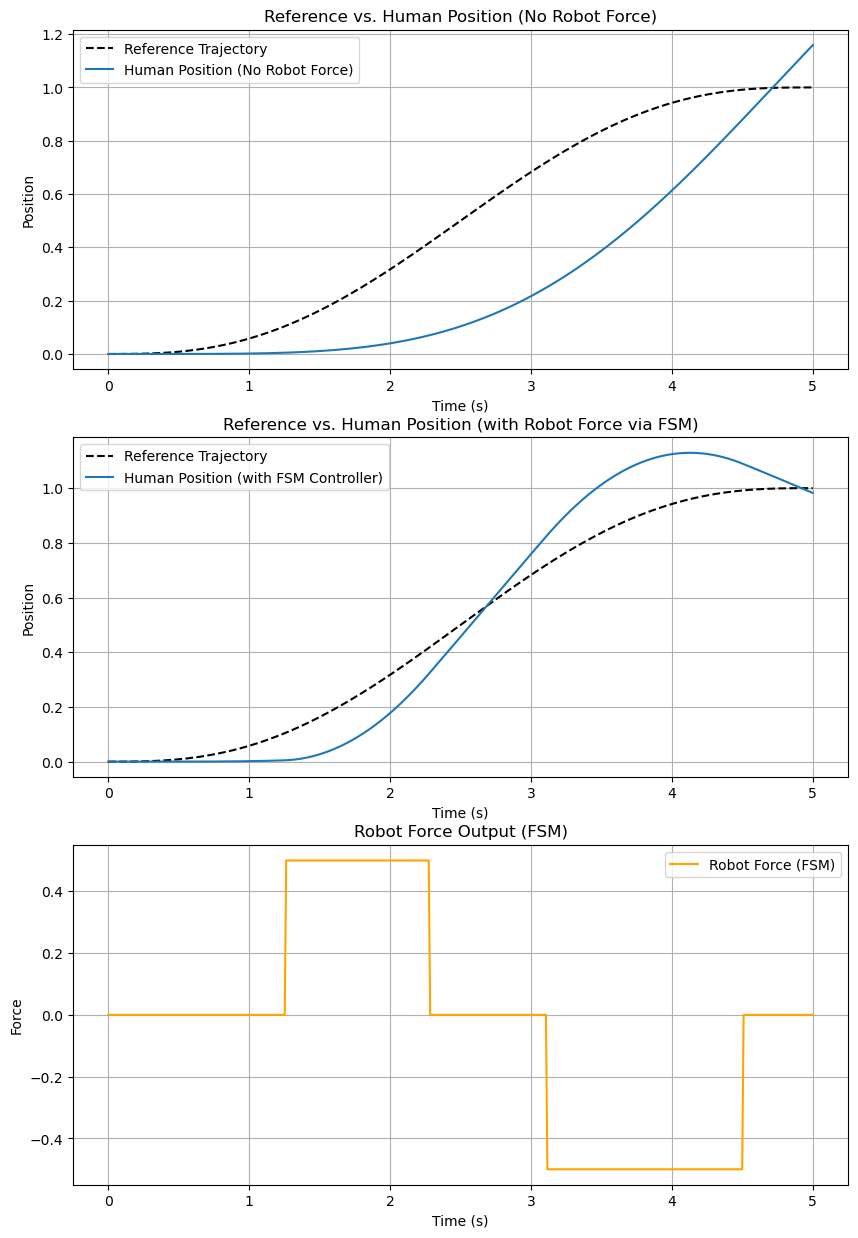

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- Minimum Jerk Trajectory ---
def minimum_jerk(t, T, x0, xf):
    """
    Compute the minimum jerk trajectory position at time t.
    Formula: x(t) = x0 + (xf - x0) * (10*(t/T)^3 - 15*(t/T)^4 + 6*(t/T)^5)
    """
    tau = t / T
    return x0 + (xf - x0) * (10*tau**3 - 15*tau**4 + 6*tau**5)

# --- FSM Controller ---
class FSMController:
    def __init__(self, threshold=0.02, assist_force=0.5, resist_force=-0.5):
        """
        Initialize the FSM controller.

        Parameters:
        - threshold: Error threshold to decide when to change state.
        - assist_force: Constant force applied when in the 'Assist' state.
        - resist_force: Constant force applied when in the 'Resist' state.
        """
        self.state = 'Neutral'
        self.threshold = threshold
        self.assist_force = assist_force
        self.resist_force = resist_force

    def update_state(self, ref, human):
        """
        Update the FSM state based on the current reference and human position.

        Rules:
        - If (ref - human) > threshold: switch to 'Assist'
        - If (ref - human) < -threshold: switch to 'Resist'
        - Otherwise, remain in 'Neutral'
        """
        error = ref - human
        if error > self.threshold:
            self.state = 'Assist'
        elif error < -self.threshold:
            self.state = 'Resist'
        else:
            self.state = 'Neutral'
        return self.state

    def get_force(self, ref, human):
        """
        Return the robot force based on the current FSM state.
        """
        state = self.update_state(ref, human)
        if state == 'Assist':
            return self.assist_force
        elif state == 'Resist':
            return self.resist_force
        else:  # Neutral
            return 0.0

# --- Simulation Setup ---
T_total = 5.0             # Total simulation time in seconds
dt = 0.01                 # Time step in seconds
num_steps = int(T_total / dt)
time = np.linspace(0, T_total, num_steps)

# Trajectory parameters (linear path from x0 to xf)
x0 = 0.0
xf = 1.0
ref_traj = np.array([minimum_jerk(t, T_total, x0, xf) for t in time])

# Human simulation parameters
mass = 1.0                # mass of the human (for dynamics)
k_human = 0.5             # proportional gain for the human's own tracking control

# --- Simulation with FSM Controller (Robot Force Applied) ---
# Initial conditions for the simulation with robot force
human_pos = 0.0           # initial human position
human_vel = 0.0           # initial human velocity

# Instantiate the FSM Controller with a chosen threshold and forces
fsm = FSMController(threshold=0.1, assist_force=0.5, resist_force=-0.5)

# Lists to record simulation data (with FSM)
human_positions = []
human_velocities = []
robot_forces = []
states = []

# Simulation loop for FSM-controlled interaction
for i in range(num_steps):
    ref = ref_traj[i]

    # Human's internal control (trying to follow the reference)
    human_control = k_human * (ref - human_pos)

    # FSM decides on the robot force based on the current error
    robot_force = fsm.get_force(ref, human_pos)

    # Total force acting on the human: human control + robot's force assistance/resistance
    total_force = human_control + robot_force

    # Update human dynamics (simple double integrator model using Euler integration)
    acceleration = total_force / mass
    human_vel += acceleration * dt
    human_pos += human_vel * dt

    # Record data for plotting
    human_positions.append(human_pos)
    human_velocities.append(human_vel)
    robot_forces.append(robot_force)
    states.append(fsm.state)

# --- Simulation without Robot Force ---
# Reset initial conditions for the simulation without robot force
human_pos_no_robot = 0.0
human_vel_no_robot = 0.0

# Lists to record simulation data (no robot force)
human_positions_no_robot = []
human_velocities_no_robot = []

# Simulation loop for human tracking without robot force
for i in range(num_steps):
    ref = ref_traj[i]
    # Only human control, no robot force is applied
    human_control = k_human * (ref - human_pos_no_robot)
    total_force = human_control  # no robot assistance or resistance

    acceleration = total_force / mass
    human_vel_no_robot += acceleration * dt
    human_pos_no_robot += human_vel_no_robot * dt

    human_positions_no_robot.append(human_pos_no_robot)
    human_velocities_no_robot.append(human_vel_no_robot)

# --- Plotting Results ---
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.plot(time, ref_traj, '--k', label='Reference Trajectory')
plt.plot(time, human_positions_no_robot, label='Human Position (No Robot Force)')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('Reference vs. Human Position (No Robot Force)')
plt.legend()
plt.grid(True)

# 1. Reference vs. Human Position (FSM Controller)
plt.subplot(3, 1, 2)
plt.plot(time, ref_traj, '--k', label='Reference Trajectory')
plt.plot(time, human_positions, label='Human Position (with FSM Controller)')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title('Reference vs. Human Position (with Robot Force via FSM)')
plt.legend()
plt.grid(True)

# 2. Robot Force over Time (FSM)
plt.subplot(3, 1, 3)
plt.plot(time, robot_forces, label='Robot Force (FSM)', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Robot Force Output (FSM)')
plt.legend()
plt.grid(True)

# # 3. FSM State over Time (encoded numerically)
# state_encoding = {'Assist': 1, 'Neutral': 0, 'Resist': -1}
# encoded_states = [state_encoding[s] for s in states]
# plt.subplot(4, 1, 3)
# plt.plot(time, encoded_states, label='FSM State', color='green')
# plt.yticks([-1, 0, 1], ['Resist', 'Neutral', 'Assist'])
# plt.xlabel('Time (s)')
# plt.ylabel('State')
# plt.title('FSM State over Time')
# plt.legend()
# plt.grid(True)

# 4. Reference vs. Human Position (No Robot Force)

plt.show()
